<a href="https://colab.research.google.com/github/UmmuKarimah/B21-CAP0156/blob/main/Text_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras

In [180]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [181]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [182]:
train = pd.read_csv('/content/gdrive/MyDrive/dataset/train.csv', encoding='latin-1')
test = pd.read_csv('/content/gdrive/MyDrive/dataset/test.csv', encoding='latin-1')
alay_dict = pd.read_csv('/content/gdrive/MyDrive/dataset/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

In [183]:
print("Shape: ", train.shape)
train.head(15)

Shape:  (10000, 2)


,Comment,sentiment
0,- disaat semua cowok berusaha melacak perhatia...,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",1
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,1
4,USER USER Kaum cebong kapir udah keliatan dong...,0
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,0
6,deklarasi pilkada 2018 aman dan anti hoax warg...,1
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,0
8,Nah admin belanja satu lagi port terbaik nak m...,1
9,USER Enak lg klo smbil ngewe',0


In [184]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


Preprocess

In [185]:
import re
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    return text

In [186]:
train['Comment'] = train['Comment'].apply(preprocess)
test['Comment'] = test['Comment'].apply(preprocess)


In [187]:
print("Shape: ", test.shape)
train.head(15)

Shape:  (3169, 2)


,Comment,sentiment
0,di saat semua cowok berusaha melacak perhatia...,0
1,siapa yang telat memberi tau kamu edan sarap ...,0
2,41 kadang aku berpikir kenapa aku tetap percay...,1
3,aku itu aku dan ku tau matamu sipit tapi dili...,1
4,kaum cebong kafir sudah kelihatan dongoknya d...,0
5,ya bani taplak dan kawan kawan xf0 x9f x98 x8...,0
6,deklarasi pilihan kepala daerah 2018 aman dan ...,1
7,gue baru saja selesai re watch aldnoah zero pa...,0
8,nah admin belanja satu lagi po terbaik nak mak...,1
9,enak lagi kalau sambil ngewe,0


In [188]:
decode_map = {0: "NEGATIF", 1: "POSITIF"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [189]:
train.sentiment = train.sentiment.apply(lambda x: decode_sentiment(x))
test.sentiment = test.sentiment.apply(lambda x: decode_sentiment(x))

In [190]:
print("TRAIN size:", len(train))
print("TEST size:", len(test))

TRAIN size: 10000
TEST size: 3169


Tokenize text

In [191]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
SEQUENCE_LENGTH=300
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train.Comment)

vocab_size = len(tokenizer.word_index) +1
print("Total words", vocab_size)

Total words 17537


In [192]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train.Comment), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.Comment), maxlen=SEQUENCE_LENGTH)

Encoder

In [193]:
labels = train.sentiment.unique().tolist()
labels

['NEGATIF', 'POSITIF']

In [194]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train.sentiment.tolist())

y_train = encoder.transform(train.sentiment.tolist())
y_test = encoder.transform(test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (10000, 1)
y_test (3169, 1)


In [195]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (10000, 300)
y_train (10000, 1)

x_test (3169, 300)
y_test (3169, 1)


In [196]:
y_train[:10]

array([[0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0]])

W2vec

In [197]:
documents = [_Comment.split() for _Comment in train.Comment] 

In [198]:
import gensim
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)



w2v_model.build_vocab(documents)



In [199]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2252


In [200]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(4079042, 5904864)

Embedding layers

In [202]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau

In [203]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i-1] = w2v_model.wv[word]
print(embedding_matrix.shape)

(2252, 300)


In [204]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

Build Model

In [205]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(units=64, recurrent_dropout = 0.3, dropout = 0.3, 
                             return_sequences = True)))
model.add(Bidirectional(LSTM(units=32, recurrent_dropout = 0.1, dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          675600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 128)          186880    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 903,761
Trainable params: 228,161
Non-trainable params: 675,600
_________________________________________________________________


In [206]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [207]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [208]:
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
141/141 [==============================] - 320s 2s/step - loss: 0.6335 - acc: 0.6318 - val_loss: 0.5221 - val_acc: 0.7380
Epoch 2/8
141/141 [==============================] - 300s 2s/step - loss: 0.4991 - acc: 0.7642 - val_loss: 0.4367 - val_acc: 0.7870
Epoch 3/8
141/141 [==============================] - 302s 2s/step - loss: 0.4328 - acc: 0.8010 - val_loss: 0.4202 - val_acc: 0.8150
Epoch 4/8
141/141 [==============================] - 301s 2s/step - loss: 0.3728 - acc: 0.8321 - val_loss: 0.4054 - val_acc: 0.8100
Epoch 5/8
141/141 [==============================] - 301s 2s/step - loss: 0.3318 - acc: 0.8572 - val_loss: 0.3896 - val_acc: 0.8250
Epoch 6/8
141/141 [==============================] - 301s 2s/step - loss: 0.3125 - acc: 0.8706 - val_loss: 0.3943 - val_acc: 0.8140
Epoch 7/8
141/141 [==============================] - 302s 2s/step - loss: 0.2670 - acc: 0.8879 - val_loss: 0.3822 - val_acc: 0.8410
Epoch 8/8
141/141 [==============================] - 302s 2s/step - loss: 0.

Evaluate

In [210]:
score = model.evaluate(x_test, y_test, batch_size=64)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

50/50 [==============================] - 14s 270ms/step - loss: 0.4799 - acc: 0.8056

ACCURACY: 0.8056169152259827
LOSS: 0.4798845946788788


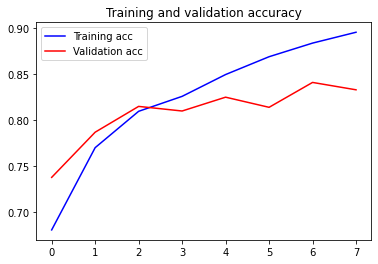

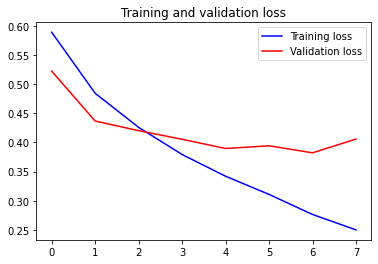

In [211]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Predict

In [212]:
def decode_sentiment(score):
    return "NEGATIVE" if score < 0.05 else "POSITIVE"

In [213]:
def predict(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score)}  

In [224]:
predict("kamu sangat jelek")

{'label': 'NEGATIVE', 'score': 0.04657870531082153}

In [223]:
predict("kamu sangat cantik")

{'label': 'POSITIVE', 'score': 0.18113180994987488}

In [226]:
predict("bangsat")

{'label': 'NEGATIVE', 'score': 0.02215901017189026}

In [225]:
model.save("text_sentiment")

INFO:tensorflow:Assets written to: text_sentiment/assets


In [ ]:
!ls text_sentiment

assets	keras_metadata.pb  saved_model.pb  variables
